In [1]:
import matplotlib.pyplot as plt

In [2]:
from __future__ import annotations
from abc import ABC, abstractmethod
from enum import Enum

class RecombinationType(Enum):
    ONE_POINT=1
    TWO_POINT=2
    UNIFORM=3
    
class MutationType(Enum):
    NORMAL=1
    FLIP_CORRELATED=2
    
class Genotype(ABC):
    '''Abstract class respresenting possible solution'''
    def __init__(self, solution=None):
        self.solution = solution if solution else self.random_solution()
        self.score = 0
        self.evaluate()
    
    def evaluate(self)-> float:
        self.score = self._evaluate()
        return self.score
    
    def mutate(self,mutation_prob:float,mutation_type:MutationType=MutationType.NORMAL) -> float:
        assert mutation_prob > 0 and mutation_prob <=1
        self._mutate(mutation_prob,mutation_type)
        self.evaluate()
    
    @abstractmethod
    def _evaluate(self) -> float:
        pass
    
    @abstractmethod
    def _mutate(self, mutation_prob:float, mutation_type: MutationType) -> None:
        pass
    
    @abstractmethod
    def random_solution(self,*args):
        pass
    
    @abstractmethod
    def recombine(self, partner, recombination_type: RecombinationType=RecombinationType.ONE_POINT) -> Genotype:
        pass

In [3]:
import random

L=50 #global variable

class LABSGenotype(Genotype):
    '''Problem-specific genotype implementation.'''
    
    def calculate_autocorrelation(self, k_value: int) -> int:
        return sum(self.solution[idx]*self.solution[idx+k_value] for idx in range(len(self.solution) - k_value ))

    def calculate_total_energy(self) -> int:
        return sum(self.calculate_autocorrelation(k_value)**2 for k_value in range(1, len(self.solution)))

    def calculate_merit_factor(self) -> float:
        return (len(self.solution)**2)/(2*self.calculate_total_energy())
    
    def _evaluate(self) -> float:
        return self.calculate_merit_factor()
    
    def random_solution(self):
        return [random.choice([-1,1]) for i in range(L)]
    
    def _mutate(self, mutation_prob: float,mutation_type:MutationType=MutationType.NORMAL) -> None:
        '''Mutation by flipping some bits.'''
        
        
        if mutation_type == MutationType.NORMAL:
            how_many_bits = int(len(self.solution)*mutation_prob)
            to_flip = random.sample(range(len(self.solution)),k=how_many_bits)

            for i in to_flip:
                self.solution[i] *= -1
        else:
            i = 0
            while i < L:
                if random.random() <= mutation_prob/2.0:
                    self.solution[i] *=-1
                    i+=2
                    if i < L:
                        self.solution[i] *=-1
                i+=1
            
    def recombine(self, partner: LABSGenotype, recombination_type: RecombinationType=RecombinationType.ONE_POINT) -> Genotype:
        new_genotype = LABSGenotype()
        
        if recombination_type == RecombinationType.ONE_POINT: 
            #single point recombination e.g. 'aaaaaaabbbbbbbb'
            
            division_point = random.choice(range(len(self.solution)-2))
            new_genotype.solution = self.solution[:division_point+1] + partner.solution[division_point+1:]
            
        elif recombination_type == RecombinationType.TWO_POINT:
            #double point recombination e.g. 'aaaabbbbbbbaaa'
            
            division_points = sorted(random.sample(range(len(self.solution)-2), k=2))
            new_genotype.solution = self.solution[:division_points[0]+1] + partner.solution[division_points[0]+1:division_points[1]+1] + self.solution[division_points[1]+1:]
            
        else:
            #uniform recombination e.g. 'abababababab'
            for i in range(len(new_genotype.solution)):
                new_genotype.solution[i] = self.solution[i] if i%2 else partner.solution[i]
        
        return new_genotype
            
        
    def __str__(self) -> str:
        return f"<Genotype: {''.join(['1' if x==1 else '0' for x in self.solution])}, mf={self.score}>"
    

genotype_class = LABSGenotype

g1 = genotype_class()
g2 = genotype_class()
recombined = g1.recombine(g2,recombination_type=RecombinationType.TWO_POINT)
print(f"Recombined:\n{g1}\n{g2}\n{recombined}")

recombined.mutate(0.26)
print(f"Mutated (normal): \n{recombined}")
recombined.mutate(0.26,MutationType.FLIP_CORRELATED)
print(f"Mutated (flip two bits at a time): \n{recombined}")

Recombined:
<Genotype: 10000110101101001001000001110001110111110110111100, mf=0.7654623392529087>
<Genotype: 11001000001010110011101111000011101001010000100100, mf=1.8796992481203008>
<Genotype: 10000110101101010011101111000011100111110110111100, mf=1.2388503468780971>
Mutated (normal): 
<Genotype: 10100110100100010000111110000011101011110110011011, mf=1.4585764294049008>
Mutated (flip two bits at a time): 
<Genotype: 10100110110000010000111110000011101011011100111011, mf=1.2794268167860798>


In [4]:
class Agent:
    def __init__(self,initial_energy:int, genotype: Genotype=None):
        self.genotype = genotype
        self.energy = initial_energy
    
    def get_score(self)->float:
        return self.genotype.score
    
    def mutate(self, mutation_prob:float, mutation_type: MutationType)->None:
        self.genotype.mutate(mutation_prob, mutation_type)
        
    def reproduce(self, partner: Agent, recombination_type: RecombinationType=RecombinationType.ONE_POINT)->Agent:
        new_genotype = self.genotype.recombine(partner.genotype,recombination_type)
        return Agent(0,new_genotype)
        
    def __str__(self) -> str:
        return f"<Agent: energy={self.energy}, genotype={self.genotype}>"

In [5]:
import time

class Simulation:
    def __init__(self, 
                 number_of_agents: int = 50, 
                 initial_energy: int = 6,
                 mutation_prob: float = 0.1,
                 mutation_type: MutationType = MutationType.NORMAL,
                 reproduction_threshold: int = 6,
                 reproduction_energy_transfer:int = 2,
                 fight_energy_transfer: int =2):
        
        self.agents = [Agent(initial_energy=initial_energy,
                             genotype=genotype_class()) for i in range(number_of_agents)]
        self.mutation_prob = mutation_prob
        self.mutation_type = mutation_type
        self.reproduction_threshold = reproduction_threshold
        self.reproduction_energy_transfer = reproduction_energy_transfer
        self.fight_energy_transfer = fight_energy_transfer
        
    def transfer_energy(self, from_agent:Agent, to_agent:Agent, amount: int) -> None:
     
        to_transfer = from_agent.energy if from_agent.energy < amount else amount
            
        from_agent.energy -= to_transfer
        to_agent.energy += to_transfer
        
        if self.is_dead(from_agent):
            self.agents.remove(from_agent)
        
        if self.is_dead(to_agent):
            self.agents.remove(to_agent)
    
    def reproduce(self, first_partner: Agent, second_partner: Agent)->None:

        new_agent = first_partner.reproduce(second_partner)
        new_agent.mutate(self.mutation_prob, self.mutation_type)
        self.agents.append(new_agent)
        
        self.transfer_energy(first_partner,new_agent,self.reproduction_energy_transfer)
        self.transfer_energy(second_partner,new_agent,self.reproduction_energy_transfer)
        
        
    def fight(self, first_fighter: Agent, second_fighter: Agent) -> None:
        #conditional mode - winner is the agent with higher score
        if first_fighter.get_score() > second_fighter.get_score():
            self.transfer_energy(second_fighter,first_fighter,self.fight_energy_transfer)
        elif second_fighter.get_score() > first_fighter.get_score():
            self.transfer_energy(first_fighter,second_fighter,self.fight_energy_transfer)
        else:
            #both solutions are equally good
            r = random.choice([0,1])
            if r:
                self.transfer_energy(second_fighter,first_fighter,self.fight_energy_transfer)
            else:
                self.transfer_energy(first_fighter,second_fighter,self.fight_energy_transfer)
                
        #else both solutions are equally good
    
        #probabilistic mode - agent with higher score has higher probability of winning
#         winner = random.choices([0,1],weights=[first_fighter.get_score()**4,second_fighter.get_score()**4],k=1)
        
#         if winner:
#             self.transfer_energy(first_fighter,second_fighter,self.fight_energy_transfer)
#         else:
#             self.transfer_energy(second_fighter,first_fighter,self.fight_energy_transfer)
        
    
    def is_dead(self, agent: Agent) -> bool:
        return agent.energy == 0
    
    def sum_energy(self)->int:
        return sum([agent.energy for agent in self.agents])
    
    def find_best(self)->Agent:
        best = self.agents[0]
        
        for agent in self.agents:
            if agent.get_score() > best.get_score():
                best = agent
                
        return best
            
    
    def step(self):
        
        random.shuffle(self.agents)
                
        fight_pool = self.agents[:int(len(self.agents)*random.uniform(0.2,0.6))]
        #fighting agents
        division_point_fight = len(fight_pool) // 2
        for agent_a, agent_b in zip(fight_pool[:division_point_fight], fight_pool[division_point_fight:]):
            self.fight(agent_a,agent_b)
            
        
        reproduction_pool = list(filter(lambda agent: agent.energy >= self.reproduction_threshold and random.random()>0.5,self.agents ))
        #reproducing agents
        division_point_repr = len(reproduction_pool) // 2
        for agent_a, agent_b in zip(reproduction_pool[:division_point_repr], reproduction_pool[division_point_repr:]):
            self.reproduce(agent_a,agent_b)
            
        return len(reproduction_pool), len(fight_pool)
        
    def simulate(self, simulation_time:float=60.0, log_interval:float=1.0)->None:
        steps = 0
        start = time.time()
        last_log_time = 0
        
        best_scores = []
        pools_length = []
        average_energy = []
        average_mf = []
        number_of_agents = []
        timestamps = []
        
        best_agent = None
        
        while time.time() - start <= simulation_time:
            r_len,f_len = self.step()

            if time.time() - last_log_time > log_interval:
                best_agent = self.find_best()
                best_scores.append(best_agent.get_score())
                pools_length.append([r_len,f_len])
                average_energy.append(sum([agent.energy for agent in self.agents])/len(self.agents))
                average_mf.append(sum([agent.get_score() for agent in self.agents])/len(self.agents))
                number_of_agents.append(len(self.agents))
                print(f"Step {steps+1} - best solution: {best_agent}")
                timestamps.append(time.time() - start)
                last_log_time = time.time()
                
            steps+=1
                
        return best_agent, best_scores, pools_length, average_energy, average_mf, number_of_agents, timestamps


In [6]:
L=20 #size of the problem

sim = Simulation(number_of_agents=50,
                 initial_energy=5,
                 mutation_prob=0.1,
                 mutation_type = MutationType.NORMAL,
                 reproduction_threshold=5,
                 reproduction_energy_transfer=2,
                 fight_energy_transfer=2)
best_agent, best_scores, pools_length, average_energy, average_mf, number_of_agents, timestamps = sim.simulate(60,1)

Step 1 - best solution: <Agent: energy=4, genotype=<Genotype: 01011111101110011010, mf=3.0303030303030303>>
Step 620 - best solution: <Agent: energy=24, genotype=<Genotype: 01011011101110001111, mf=4.761904761904762>>
Step 1388 - best solution: <Agent: energy=3, genotype=<Genotype: 01010010011000111111, mf=4.761904761904762>>
Step 2114 - best solution: <Agent: energy=20, genotype=<Genotype: 10010011000010101111, mf=5.2631578947368425>>
Step 2777 - best solution: <Agent: energy=24, genotype=<Genotype: 10010011000010101111, mf=5.2631578947368425>>
Step 3461 - best solution: <Agent: energy=10, genotype=<Genotype: 10010011000010101111, mf=5.2631578947368425>>
Step 3919 - best solution: <Agent: energy=9, genotype=<Genotype: 10010011000010101111, mf=5.2631578947368425>>
Step 4344 - best solution: <Agent: energy=5, genotype=<Genotype: 10010011000010101111, mf=5.2631578947368425>>
Step 4991 - best solution: <Agent: energy=9, genotype=<Genotype: 10010011000010101111, mf=5.2631578947368425>>
Ste

In [7]:
print(f"Best solution: {best_agent}")

Best solution: <Agent: energy=0, genotype=<Genotype: 10010011000010101111, mf=5.2631578947368425>>


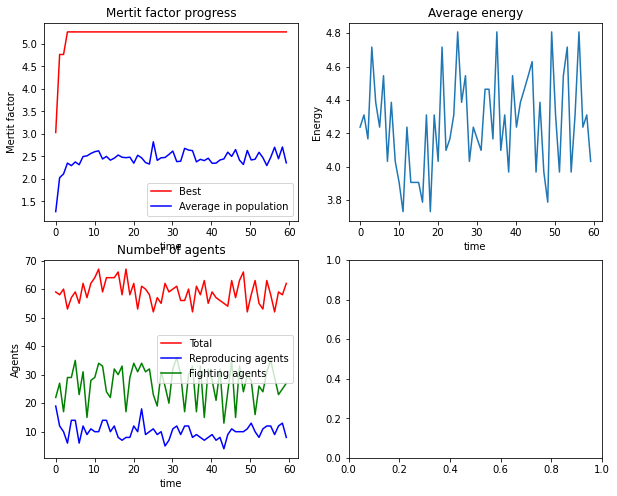

In [8]:
import matplotlib.pyplot as plt
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(10,8))

ax1.plot(timestamps, best_scores,'r',timestamps,average_mf,'b-')
ax1.set_title('Mertit factor progress')
ax1.set_ylabel('Mertit factor')
ax1.set_xlabel('time')
ax1.legend(['Best','Average in population'])

ax2.plot(timestamps,average_energy)
ax2.set_title("Average energy")
ax2.set_ylabel("Energy")
ax2.set_xlabel("time")

ax3.plot(timestamps,number_of_agents,'r',timestamps,[row[0] for row in pools_length],'b',timestamps,[row[1] for row in pools_length],'g')
ax3.set_ylabel('Agents')
ax3.set_xlabel('time')
ax3.set_title('Number of agents')
ax3.legend(['Total','Reproducing agents','Fighting agents'])

plt.show()

In [9]:
import pandas as pd

def multirun_simulation(sim_params,sim_time=60.0,log_interval=1.0,number_of_runs=10):
    aggregated = {
        'best_agent': [],
        'best_scores': [],
        'pools_length': [],
        'average_energy': [],
        'average_mf': [],
        'number_of_agents': [],
        'timestamps': []
    }
    print(f"Simulation params: {sim_params}")
    
    for i in range(number_of_runs):
        print(f"***** Simulation run number {i+1}/{number_of_runs} *****")
        sim = Simulation(**sim_params)
        
        best_agent, best_scores, pools_length, average_energy, \
        average_mf, number_of_agents, timestamps = sim.simulate(sim_time,log_interval)
        
        aggregated['best_agent'].append(best_agent)
        aggregated['best_scores'].append(best_scores)
        aggregated['pools_length'].append(pools_length)
        aggregated['average_energy'].append(average_energy)
        aggregated['average_mf'].append(average_mf)
        aggregated['number_of_agents'].append(number_of_agents)
        aggregated['timestamps'].append(timestamps)
        
    return aggregated
        

In [10]:
# L=20
# simulation_params = {
#     'number_of_agents':70,
#     'initial_energy':5,
#     'mutation_prob':0.1,
#     'mutation_type': MutationType.NORMAL,
#     'reproduction_threshold':5,
#     'reproduction_energy_transfer':2,
#     'fight_energy_transfer':2
# }
# data = multirun_simulation(simulation_params,60,1,10)

In [11]:
L=101

simulation_params = {
    'number_of_agents':5000,
    'initial_energy':6,
    'mutation_prob':0.05,
    'mutation_type': MutationType.NORMAL,
    'reproduction_threshold':5,
    'reproduction_energy_transfer':2,
    'fight_energy_transfer':2
}
# data2 = multirun_simulation(simulation_params,10*60,2,10)

In [13]:
# import statistics

# plt.figure(figsize=(15,5))
# # plt.boxplot([s for s in zip(*data2['best_scores'])])
# plt.plot([statistics.mean(s) for s in zip(*data2['best_scores'])])
# plt.title('Average best mertif factor')
# plt.ylabel('Mertit factor')

# plt.show()

In [14]:
#TODO: run tests for different mutation_prob (suggested:2,5,10,15%) and plot together

In [15]:
L=101
mutation_prob_search_list = [0.02,0.05,0.1,0.15]
simulation_params = {
    'number_of_agents':5000,
    'initial_energy':6,
    'mutation_prob': mutation_prob_search_list[0],
    'mutation_type': MutationType.NORMAL,
    'reproduction_threshold':5,
    'reproduction_energy_transfer':2,
    'fight_energy_transfer':2
}
mutation_normal = []

for mutation_prob in mutation_prob_search_list:
    simulation_params['mutation_prob'] = mutation_prob
    data = multirun_simulation(simulation_params,10*60,2,10)
    mutation_normal.append(data)
    
simulation_params['mutation_type'] = MutationType.FLIP_CORRELATED

mutation_flip_correlated = []
for mutation_prob in mutation_prob_search_list:
    simulation_params['mutation_prob'] = mutation_prob
    data = multirun_simulation(simulation_params,10*60,2,10)
    mutation_flip_correlated.append(data)

Simulation params: {'number_of_agents': 5000, 'initial_energy': 6, 'mutation_prob': 0.02, 'mutation_type': <MutationType.NORMAL: 1>, 'reproduction_threshold': 5, 'reproduction_energy_transfer': 2, 'fight_energy_transfer': 2}
***** Simulation run number 1/10 *****
Step 1 - best solution: <Agent: energy=4, genotype=<Genotype: 01011001011101001010100110000000100111011010101110010101110000001101011111110110011000011111110011010, mf=1.954214559386973>>
Step 2 - best solution: <Agent: energy=4, genotype=<Genotype: 01011001011101001010100110000000100111011010101110010101110000001101011111110110011000011111110011010, mf=1.954214559386973>>
Step 3 - best solution: <Agent: energy=6, genotype=<Genotype: 01011001011101001010100110000000100111011010101110010101110000001101011111110110011000011111110011010, mf=1.954214559386973>>
Step 4 - best solution: <Agent: energy=6, genotype=<Genotype: 01011001011101001010100110000000100111011010101110010101110000001101011111110110011000011111110011010, mf=1.95

In [24]:
import pickle
with open("mutation_normal.pickle", "wb") as file_:
    pickle.dump(mutation_normal, file_)
    
with open("mutation_flip_correlated.pickle", "wb") as file_:
    pickle.dump(mutation_flip_correlated, file_)

In [25]:
L=101
mutation_prob_search_list = [0.02,0.05,0.1,0.15]
simulation_params = {
    'number_of_agents':5000,
    'initial_energy':6,
    'mutation_prob': mutation_prob_search_list[0],
    'mutation_type': MutationType.NORMAL,
    'reproduction_threshold':5,
    'reproduction_energy_transfer':2,
    'fight_energy_transfer':2
}
simulation_params['mutation_type'] = MutationType.FLIP_CORRELATED

with open("mutation_normal.pickle", "rb") as file_:
    mut_cor = pickle.load(file_)
    
with open("mutation_flip_correlated.pickle", "rb") as file_:
    mut_fl_cor = pickle.load(file_)
    

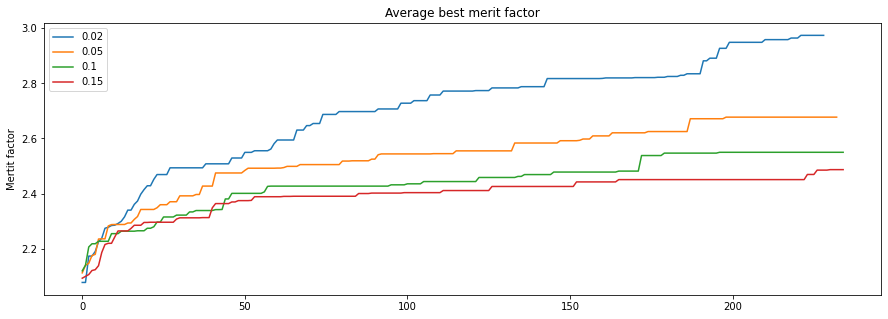

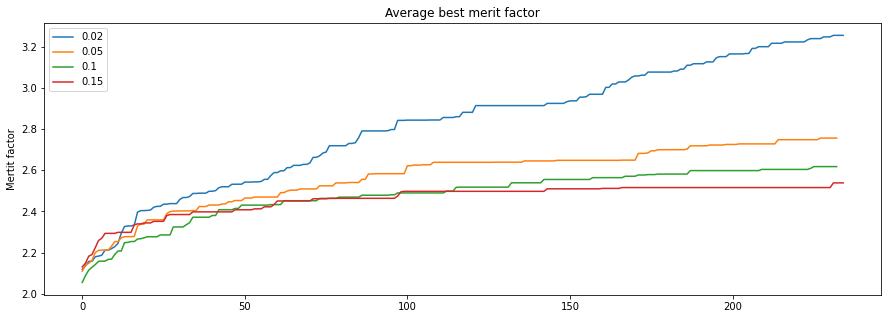

In [73]:
import statistics

plt.figure(figsize=(15,5))
for run_data in mut_cor:
    # plt.boxplot([s for s in zip(*run_data['best_scores'])])
    plt.plot([statistics.mean(s) for s in zip(*run_data['best_scores'])])
    plt.title('Average best merit factor')
    plt.ylabel('Mertit factor')
plt.legend(mutation_prob_search_list)
plt.show()

plt.figure(figsize=(15,5))
for run_data in mut_fl_cor:
    # plt.boxplot([s for s in zip(*run_data['best_scores'])])
    plt.plot([statistics.mean(s) for s in zip(*run_data['best_scores'])])
    plt.title('Average best merit factor')
    plt.ylabel('Mertit factor')
plt.legend(mutation_prob_search_list)
plt.show()

# Plot analisis
It's easily noticable that the lowest mutation probabilites rendered highest merit factor. For mutation chance 0.02 final results were 8% and 15% higgher consecutively.